Our prediction target for the regression is the mass attribute, as we stated it in our previous report. The mass will be predicted based on the following attributes: distance, stellar_magnitude, orbital_radius, orbital_period, eccentricity and radius attributes.

Our goal is to create a model that not only performs well on the training set, but also on the test set.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
dataset = pd.read_csv("data/cleaned_5250.csv")
missing_values_idx = dataset.isna().any(axis=1)
clean_dataset = dataset[~missing_values_idx]
clean_dataset.shape

(4765, 13)

In [18]:
num_obeservation = 4000
df = clean_dataset.iloc[range(num_obeservation)]
full_df = df.copy()
df = df.drop("name", axis=1)

In [19]:
# mass transformation: The dataset contains a mass calculation based on two planets. We unify that into a single mass variable
jupiter_mass_kg = 1.898 * 10**27 #kg
jupiter_radius_km = 69911 #km
earth_mass_kg = 5.972 * 10**24
earth_radius_km = 6378
df["mass_wrt"] = np.where(df["mass_wrt"] == "Jupiter", jupiter_mass_kg, earth_mass_kg)
df["mass"] = np.multiply(df["mass_multiplier"], df["mass_wrt"])
df["radius_wrt"] = np.where(df["radius_wrt"] == "Jupiter", jupiter_radius_km, earth_radius_km)
df["radius"] = np.multiply(df["radius_multiplier"], df["radius_wrt"])
df = df.drop(["mass_wrt", "radius_wrt", "mass_multiplier", "radius_multiplier"], axis=1)
print(df, df.shape)

      distance  stellar_magnitude   planet_type  discovery_year  \
0        304.0            4.72307     Gas Giant            2007   
1        409.0            5.01300     Gas Giant            2009   
2        246.0            5.23133     Gas Giant            2008   
3         58.0            6.61935     Gas Giant            2002   
4         69.0            6.21500     Gas Giant            1996   
...        ...                ...           ...             ...   
4260    7849.0           16.06200  Neptune-like            2016   
4261    3197.0           14.67200  Neptune-like            2016   
4262    2942.0           15.57600  Neptune-like            2016   
4263    3601.0           15.42400  Neptune-like            2016   
4264    3081.0           13.69300  Neptune-like            2016   

      orbital_radius  orbital_period  eccentricity detection_method  \
0           1.290000        0.892539          0.23  Radial Velocity   
1           1.530000        1.400000          0.08  R

In [20]:

planet_type = df["planet_type"]
encoded_df = df.copy()
#we encode the categorical variables, to make it digestable for the training stage later
encoded_df["detection_method"] = encoded_df["detection_method"].astype("category").cat.codes
encoded_df["planet_type"] = encoded_df["planet_type"].astype("category").cat.codes
encoded_df["discovery_year"] = encoded_df["discovery_year"].astype("category").cat.codes

#we have a separate df, so that the standardization is only done for the non-categorical variables
df_without_type = encoded_df.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)

df_std = (df_without_type - np.mean(df_without_type, axis=0)) / np.std(df_without_type, axis=0)
print(np.std(df_std, axis=0))

#we add back everything
df_std["planet_type"] = encoded_df["planet_type"]
df_std["detection_method"] = encoded_df["detection_method"]
df_std["discovery_year"] = encoded_df["discovery_year"]
df_std

distance             1.0
stellar_magnitude    1.0
orbital_radius       1.0
orbital_period       1.0
eccentricity         1.0
mass                 1.0
radius               1.0
dtype: float64


,distance,stellar_magnitude,orbital_radius,orbital_period,eccentricity,mass,radius,planet_type,detection_method,discovery_year
0,-0.941502,-2.507892,-0.029399,-0.020411,1.082079,1.344301,1.380098,0,5,11
1,-0.876496,-2.416469,-0.027530,-0.020383,0.068518,0.995118,1.402200,0,5,13
2,-0.977410,-2.347623,-0.032981,-0.020433,-0.472049,0.250294,1.534811,0,5,12
3,-1.093801,-1.909940,-0.017851,-0.020190,2.028070,0.500477,1.468505,0,5,6
4,-1.086991,-2.037443,-0.026518,-0.020337,4.122764,0.023999,1.645320,0,5,1
...,...,...,...,...,...,...,...,...,...,...
4260,3.729620,1.067600,-0.038611,-0.020460,-0.472049,-0.107447,-0.456561,1,6,20
4261,0.849559,0.629293,-0.038655,-0.020460,-0.472049,-0.107518,-0.467612,1,6,20
4262,0.691688,0.914350,-0.038553,-0.020460,-0.472049,-0.107711,-0.502975,1,6,20
4263,1.099676,0.866420,-0.038458,-0.020460,-0.472049,-0.107518,-0.467612,1,6,20


In [21]:
planet_cats = df["planet_type"].astype("category")
print(planet_cats.cat.categories) 
detection_cats = df["detection_method"].astype("category")
print(detection_cats.cat.categories)
discovery_cats = df["discovery_year"].astype("category")
print(discovery_cats.cat.categories) 


Index(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial'], dtype='object')
Index(['Astrometry', 'Direct Imaging', 'Disk Kinematics',
       'Eclipse Timing Variations', 'Orbital Brightness Modulation',
       'Radial Velocity', 'Transit', 'Transit Timing Variations'],
      dtype='object')
Index([1995, 1996, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023],
      dtype='int64')


In [22]:
df_regression = df_std.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)
df_regression

,distance,stellar_magnitude,orbital_radius,orbital_period,eccentricity,mass,radius
0,-0.941502,-2.507892,-0.029399,-0.020411,1.082079,1.344301,1.380098
1,-0.876496,-2.416469,-0.027530,-0.020383,0.068518,0.995118,1.402200
2,-0.977410,-2.347623,-0.032981,-0.020433,-0.472049,0.250294,1.534811
3,-1.093801,-1.909940,-0.017851,-0.020190,2.028070,0.500477,1.468505
4,-1.086991,-2.037443,-0.026518,-0.020337,4.122764,0.023999,1.645320
...,...,...,...,...,...,...,...
4260,3.729620,1.067600,-0.038611,-0.020460,-0.472049,-0.107447,-0.456561
4261,0.849559,0.629293,-0.038655,-0.020460,-0.472049,-0.107518,-0.467612
4262,0.691688,0.914350,-0.038553,-0.020460,-0.472049,-0.107711,-0.502975
4263,1.099676,0.866420,-0.038458,-0.020460,-0.472049,-0.107518,-0.467612


In [23]:
# Define features, and target variable
X = df_without_type.drop(columns=['mass']).values
y = df_without_type['mass'].values
print(X.shape, y.shape)

(4000, 6) (4000,)


In [24]:
y

array([3.682120e+28, 2.797652e+28, 9.110400e+27, ..., 4.228176e+25,
       4.717880e+25, 4.258036e+25], shape=(4000,))

In [ ]:

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [84]:
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
y_mean = np.mean(y)
y_std = np.std(y)

X_scaled = (X - X_mean) / X_std
y_scaled = (y - y_mean) / y_std

In [ ]:
lambdas = np.linspace(10, 5000, 50)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

train_errors = []
test_errors = []

In [ ]:

for lam in lambdas:
    ridge = Ridge(alpha=lam)
    fold_train_errors = []
    fold_test_errors = []
    
    for train_idx, test_idx in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]
        
        ridge.fit(X_train, y_train)
        
        y_pred_train = ridge.predict(X_train)
        y_pred_test = ridge.predict(X_test)
        
        fold_train_errors.append(mean_squared_error(y_train, y_pred_train))
        fold_test_errors.append(mean_squared_error(y_test, y_pred_test))
    
    train_errors.append(np.mean(fold_train_errors))
    test_errors.append(np.mean(fold_test_errors))




In [ ]:
#optimal lambda
optimal_idx = np.argmin(test_errors)
optimal_lambda = lambdas[optimal_idx]
optimal_error = test_errors[optimal_idx]

print(f"Optimal lambda = {optimal_lambda:.4f}")
print(f"Minimum Cross-Validation error = {optimal_error:.4f}")

Optimal lambda = 1639.3878
Minimum Cross-Validation error = 0.9425


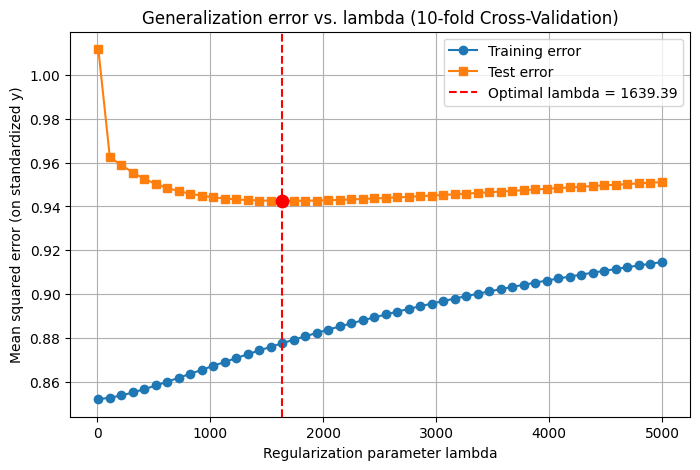

In [ ]:

plt.figure(figsize=(8, 5))
plt.plot(lambdas, train_errors, marker='o', label='Training error')
plt.plot(lambdas, test_errors, marker='s', label='Test error')

# Highlight optimal lambda
plt.axvline(optimal_lambda, color='red', linestyle='--', label=f'Optimal lambda = {optimal_lambda:.2f}')
plt.scatter(optimal_lambda, optimal_error, color='red', s=80, zorder=5)

# Labels and legend
plt.xlabel('Regularization parameter lambda')
plt.ylabel('Mean squared error (on standardized y)')
plt.title('Generalization error vs. lambda (10-fold Cross-Validation)')
plt.legend()
plt.grid(True)
plt.show()

In [96]:
ridge = Ridge(alpha=optimal_lambda)

ridge.fit(X_train, y_train)
coeffs = ridge.coef_
intercept = ridge.intercept_

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

train_error = mean_squared_error(y_train, y_pred_train)
test_error = mean_squared_error(y_test, y_pred_test)

coeffs, intercept, train_error, test_error

(array([ 0.01465216,  0.00783313,  0.01786578, -0.01083959, -0.02354344,
         0.26368187]),
 np.float64(-0.003973824879662343),
 0.9280664689308191,
 0.4492873840824727)

As we see the last coefficient is the most signifacnt. This coefficient is the radius. This is in line with our previous analysis from the correlation matrix which also showed the strongest correlation between these 2 attributes.

In [158]:
K1 = 10  # outer folds
K2 = 10  # inner folds

# Regularization and ANN hyperparameters
lambdas = np.linspace(10, 5000, 50)
hidden_units = [1, 8, 16, 32, 64, 128]

In [159]:
# Storage
test_errors_outer = {
    'baseline': np.zeros(K1),
    'ridge': np.zeros(K1),
    'ann': np.zeros(K1)
}

In [160]:
optimal_hs = np.zeros(K1)
optimal_lambdas = np.zeros(K1)

In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class PredictorANN(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super(PredictorANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.model(x)

In [162]:
def train_custom_ann(X_train, y_train, X_val, y_val, hidden_units, 
                      lr=1e-3, weight_decay=0.0, epochs=200, batch_size=32, verbose=False):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert numpy arrays to torch tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32).to(device)

    # Datasets and loaders
    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Initialize model, loss, optimizer
    model = PredictorANN(X_train.shape[1], hidden_units).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = criterion(val_preds, y_val_t).item()

    return val_loss, model


In [163]:
# Outer cross-validation loop
from sklearn.neural_network import MLPRegressor


outer_cv = KFold(K1, shuffle=True)

for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X, y)):
    print(f"Outer fold {outer_fold + 1}/{K1}")

    X_train_outer, y_train_outer = X[outer_train_idx], y[outer_train_idx]
    X_test_outer, y_test_outer = X[outer_test_idx], y[outer_test_idx]

    # Standardize (based on training data)
    X_train_mean = np.mean(X_train_outer, axis=0)
    X_train_std = np.std(X_train_outer, axis=0)

    X_test_mean = np.mean(X_test_outer, axis=0)
    X_test_std = np.std(X_test_outer, axis=0)

    Y_train_mean = np.mean(y_train_outer)
    Y_train_std = np.std(y_train_outer)

    y_test_mean = np.mean(y_test_outer)
    y_test_std = np.std(y_test_outer)

    X_train_outer = (X_train_outer - X_train_mean) / X_train_std
    X_test_outer = (X_test_outer - X_test_mean) / X_test_std
    y_train_outer = (y_train_outer - Y_train_mean) / Y_train_std
    y_test_outer = (y_test_outer - y_test_mean) / y_test_std

    # BASELINE MODEL
    y_pred_baseline = np.full_like(y_test_outer, np.mean(y_train_outer))
    test_errors_outer['baseline'][outer_fold] = np.mean((y_test_outer - y_pred_baseline) ** 2)

    #INNER CV for Ridge
    inner_cv = KFold(K2, shuffle=True)
    ridge_val_errors = np.zeros(len(lambdas))

    for i, lam in enumerate(lambdas):
        inner_errors = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            model = Ridge(alpha=lam)
            model.fit(X_train_inner, y_train_inner)
            y_val_pred = model.predict(X_val_inner)
            inner_errors.append(mean_squared_error(y_val_inner, y_val_pred))
        ridge_val_errors[i] = np.mean(inner_errors)

    optimal_lambda = lambdas[np.argmin(ridge_val_errors)]
    optimal_lambdas[outer_fold] = optimal_lambda

    # Train Ridge on full outer training set
    ridge_model = Ridge(alpha=optimal_lambda)
    ridge_model.fit(X_train_outer, y_train_outer)
    ridge_test_error = np.mean((y_test_outer - ridge_model.predict(X_test_outer)) ** 2)
    test_errors_outer['ridge'][outer_fold] = ridge_test_error

    # ----- INNER CV for ANN (PyTorch version) -----
    ann_val_errors = np.zeros(len(hidden_units))

    for j, h in enumerate(hidden_units):
        inner_errors = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            val_loss, _ = train_custom_ann(X_train_inner, y_train_inner, X_val_inner, y_val_inner,
                                            hidden_units=h, lr=1e-3, epochs=10)
            inner_errors.append(val_loss)
        ann_val_errors[j] = np.mean(inner_errors)

    optimal_h = hidden_units[np.argmin(ann_val_errors)]
    optimal_hs[outer_fold] = optimal_h

    # Train final ANN model on full outer training set
    _, ann_model = train_custom_ann(X_train_outer, y_train_outer, X_test_outer, y_test_outer,
                                    hidden_units=optimal_h, lr=1e-3, epochs=10)
    ann_model.eval()

    device = next(ann_model.parameters()).device  # get model’s device
    X_test_t = torch.tensor(X_test_outer, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test_outer.reshape(-1, 1), dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_t = ann_model(X_test_t).cpu().numpy().flatten()

    ann_test_error = mean_squared_error(y_test_outer, y_pred_t)
    test_errors_outer['ann'][outer_fold] = ann_test_error


# Results summary
print("\nMean test errors across outer folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")

Outer fold 1/10
Outer fold 2/10
Outer fold 3/10
Outer fold 4/10
Outer fold 5/10
Outer fold 6/10
Outer fold 7/10
Outer fold 8/10
Outer fold 9/10
Outer fold 10/10

Mean test errors across outer folds:
baseline  : 1.0000 ± 0.0000
ridge     : 0.8532 ± 0.0688
ann       : 0.8167 ± 0.0667


In [164]:
# Summarize Results in Table
results_df = pd.DataFrame({
    'Fold': np.arange(1, K1 + 1),
    'lambda* (Ridge)': optimal_lambdas,
    'h* (ANN)': optimal_hs,
    'Baseline Test Error': test_errors_outer['baseline'],
    'Ridge Test Error': test_errors_outer['ridge'],
    'ANN Test Error': test_errors_outer['ann']
})

# Display the table
print("\n===== Table 1: Cross-Validation Results =====")
print(results_df.to_string(index=False))

# Summary statistics
print("\nMean ± Std of Test Errors across folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")


===== Table 1: Cross-Validation Results =====
 Fold  lambda* (Ridge)  h* (ANN)  Baseline Test Error  Ridge Test Error  ANN Test Error
    1      1944.897959      32.0                  1.0          0.892162        0.860988
    2      1639.387755      64.0                  1.0          0.898815        0.821602
    3      1944.897959      32.0                  1.0          0.877494        0.825220
    4      1232.040816      32.0                  1.0          0.833791        0.798284
    5      1741.224490       8.0                  1.0          0.850196        0.873263
    6      1741.224490      16.0                  1.0          0.822160        0.778422
    7      1333.877551      32.0                  1.0          0.898698        0.877876
    8        10.000000     128.0                  1.0          0.663885        0.638725
    9      1639.387755     128.0                  1.0          0.899929        0.834228
   10      1741.224490      32.0                  1.0          0.895193  